# LifeHarmony: Preliminary Application

This notebook demonstrates how to use the trained LifeHarmony deep learning model to build a preliminary application. We'll create a simple yet functional interface that allows users to input their information and receive personalized life balance recommendations.

## 1. Setup and Imports
Let's start by importing the necessary libraries and loading our trained model.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from matplotlib.colors import LinearSegmentedColormap


# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set working directory to where your .py file is
import os
project_path = "/content/drive/MyDrive/DLProject30April"
os.chdir(project_path)

# Step 3: Add the path to sys.path so imports work
import sys
if project_path not in sys.path:
    sys.path.append(project_path)

from deep_learning_model import train_model


Mounted at /content/drive


In [2]:
# Define paths to model files
model_path = "harmony_deep_model.h5"
recommendations_path = "harmony_deep_model_recommendations.pkl"
scaler_path = "harmony_deep_model_scaler.pkl"

# Check if files exist in the current directory, if not, adjust paths
if not os.path.exists(model_path):
    base_path = "deployment/"
    model_path = os.path.join(base_path, model_path)
    recommendations_path = os.path.join(base_path, recommendations_path)
    scaler_path = os.path.join(base_path, scaler_path)

# Load the trained model
model_path = "/content/drive/MyDrive/DLProject30April/harmony_deep_model.h5"
print("Model loaded successfully.")

# Load the recommendation mapping
with open(recommendations_path, "rb") as f:
    unique_recommendations = pickle.load(f)
print(f"Loaded {len(unique_recommendations)} unique recommendations.")

# Load the scaler
with open(scaler_path, "rb") as f:
    scaler = pickle.load(f)
print("Scaler loaded successfully.")

# Define feature mappings
marital_status_mapping = {"Single": 0, "Married": 1}
marital_status_reverse = {v: k for k, v in marital_status_mapping.items()}

occupation_mapping = {
    "Full-time": 0,
    "Part-time": 1,
    "Freelancer": 2,
    "Student": 3,
    "Unemployed": 4
}
occupation_reverse = {v: k for k, v in occupation_mapping.items()}

personality_mapping = {"Extrovert": 0, "Introvert": 1, "Ambivert": 2}
personality_reverse = {v: k for k, v in personality_mapping.items()}

hobby_mapping = {
    "Exercise": 0,
    "Reading": 1,
    "Writing": 2,
    "Art": 3,
    "Socializing": 4
}
hobby_reverse = {v: k for k, v in hobby_mapping.items()}

priority_mapping = {"Low": 0, "Medium": 1, "High": 2}
priority_reverse = {v: k for k, v in priority_mapping.items()}

Model loaded successfully.
Loaded 40 unique recommendations.
Scaler loaded successfully.


## Recommendation Function
Now, let's define a function to generate recommendations for a given user profile.

In [3]:
# Define model, scaler, and recommendations as global variables
global_model = None
global_scaler = None
global_recommendations = None

def load_model_resources():
    """Load model, scaler, and recommendations into global variables."""
    global global_model, global_scaler, global_recommendations

    # Define paths to model files
    model_path = "harmony_deep_model.h5"
    recommendations_path = "harmony_deep_model_recommendations.pkl"
    scaler_path = "harmony_deep_model_scaler.pkl"

    # Check if files exist in the current directory, if not, adjust paths
    if not os.path.exists(model_path):
        base_path = "deployment/"
        model_path = os.path.join(base_path, model_path)
        recommendations_path = os.path.join(base_path, recommendations_path)
        scaler_path = os.path.join(base_path, scaler_path)

    # Load the trained model
    global_model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully.")

    # Load the recommendation mapping
    with open(recommendations_path, "rb") as f:
        global_recommendations = pickle.load(f)
    print(f"Loaded {len(global_recommendations)} unique recommendations.")

    # Load the scaler
    with open(scaler_path, "rb") as f:
        global_scaler = pickle.load(f)
    print("Scaler loaded successfully.")

# Call the function to load resources
load_model_resources()

def get_recommendations(user_features, threshold=0.3, top_k=10):
    """
    Generate recommendations for a user.

    Parameters:
    -----------
    user_features : list
        List of user features
    threshold : float, default=0.3
        Probability threshold for recommendations
    top_k : int, default=10
        Maximum number of recommendations to return

    Returns:
    --------
    list
        List of recommended activities with their probabilities
    """
    global global_model, global_scaler, global_recommendations

    # Make sure resources are loaded
    if global_model is None or global_scaler is None or global_recommendations is None:
        print("Error: Model resources not loaded. Running load_model_resources()...")
        load_model_resources()

    # Prepare input
    user_features = np.array(user_features).reshape(1, -1)

    # Apply scaling to Age and Budget (assumes these are at indices 0 and 3)
    user_features_scaled = user_features.copy()
    user_features_scaled[:, [0, 3]] = global_scaler.transform(user_features[:, [0, 3]])

    # Get predictions
    predictions = global_model.predict(user_features_scaled)[0]

    # Method 1: Threshold-based selection
    recommended_indices = np.where(predictions > threshold)[0]

    # Method 2: If too few or too many recommendations, use top-k
    if len(recommended_indices) < 3 or len(recommended_indices) > top_k:
        recommended_indices = np.argsort(predictions)[-top_k:]

    # Get recommendations with probabilities
    recommendations_with_probs = [
        (global_recommendations[i], float(predictions[i]))
        for i in recommended_indices
    ]

    # Sort by probability
    recommendations_with_probs.sort(key=lambda x: x[1], reverse=True)

    return recommendations_with_probs

Model loaded successfully.
Loaded 40 unique recommendations.
Scaler loaded successfully.


## Wheel of Life Visualization
Let's create a function to visualize the Wheel of Life for a user, showing their current priorities.

In [4]:
def plot_wheel_of_life(priorities, ax=None):
    """
    Plot the Wheel of Life visualization.

    Parameters:
    -----------
    priorities : dict
        Dictionary of life domains and their priority values
    ax : matplotlib.axes, optional
        Axes to plot on

    Returns:
    --------
    matplotlib.axes
        The axes containing the plot
    """
    # Define domains and their order
    domains = ["Career", "Financial", "Spiritual", "Physical",
              "Intellectual", "Family", "Social", "Fun"]

    # Map priority labels to numerical values for visualization (0-10 scale)
    priority_to_value = {"Low": 3, "Medium": 6, "High": 9}
    values = [priority_to_value[priorities[domain]] for domain in domains]

    # Create a new plot if ax is not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Number of domains
    N = len(domains)

    # Angles for each domain (divide the plot into equal parts)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()

    # Make the plot circular by repeating the first value
    values += values[:1]
    angles += angles[:1]
    domains += domains[:1]

    # Draw the priority levels (concentric circles)
    ax.set_ylim(0, 10)
    ax.set_yticks([3, 6, 9])
    ax.set_yticklabels(["Low", "Medium", "High"])

    # Create custom colormap for filling
    colors = [(0.9, 0.2, 0.2), (0.9, 0.6, 0.3), (0.3, 0.6, 0.9)]
    cmap = LinearSegmentedColormap.from_list("priority_colors", colors, N=3)

    # Plot data
    ax.plot(angles, values, linewidth=2, linestyle='solid', color='blue')

    # Fill the area
    ax.fill(angles, values, alpha=0.25, color='blue')

    # Set the angular ticks
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(domains[:-1])

    # Add a title
    ax.set_title("Life Balance Wheel", size=20, y=1.05)

    # Add priority level circles with labels
    for i, r in enumerate([3, 6, 9]):
        ax.text(-0.4, r, ["Low", "Medium", "High"][i],
                ha='center', va='center', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

    return ax

## Interactive User Interface
Now, let's create an interactive interface using ipywidgets to allow users to input their information and receive recommendations.

In [5]:
def create_user_interface():
    """Create an interactive user interface for the LifeHarmony application."""

    # Create input widgets
    age_slider = widgets.IntSlider(
        value=35, min=12, max=70, step=1, description='Age:',
        continuous_update=False, style={'description_width': '100px'}
    )

    marital_status_dropdown = widgets.Dropdown(
        options=list(marital_status_mapping.keys()),
        value='Single',
        description='Marital Status:',
        style={'description_width': '100px'}
    )

    occupation_dropdown = widgets.Dropdown(
        options=list(occupation_mapping.keys()),
        value='Full-time',
        description='Occupation:',
        style={'description_width': '100px'}
    )

    budget_slider = widgets.IntSlider(
        value=3000, min=0, max=7000, step=100, description='Budget ($/month):',
        continuous_update=False, style={'description_width': '100px'}
    )

    personality_dropdown = widgets.Dropdown(
        options=list(personality_mapping.keys()),
        value='Ambivert',
        description='Personality:',
        style={'description_width': '100px'}
    )

    hobby_dropdown = widgets.Dropdown(
        options=list(hobby_mapping.keys()),
        value='Reading',
        description='Primary Hobby:',
        style={'description_width': '100px'}
    )

    # Create priority selection widgets for each life domain
    domains = ["Career", "Financial", "Spiritual", "Physical",
               "Intellectual", "Family", "Social", "Fun"]

    priority_dropdowns = {}
    priority_widgets = []

    for domain in domains:
        dropdown = widgets.Dropdown(
            options=list(priority_mapping.keys()),
            value='Medium',
            description=f'{domain} Priority:',
            style={'description_width': '100px'}
        )
        priority_dropdowns[domain] = dropdown
        priority_widgets.append(dropdown)

    # Create a button to generate recommendations
    generate_button = widgets.Button(
        description='Generate Recommendations',
        button_style='success',
        icon='check'
    )

    # Create output widgets
    output_recommendations = widgets.Output()
    output_visualization = widgets.Output()

    # Define button click handler
    def on_button_clicked(b):
        # Clear previous outputs
        output_recommendations.clear_output()
        output_visualization.clear_output()

        # Gather user feature values
        user_features = [
            age_slider.value,
            marital_status_mapping[marital_status_dropdown.value],
            occupation_mapping[occupation_dropdown.value],
            budget_slider.value,
            personality_mapping[personality_dropdown.value],
            hobby_mapping[hobby_dropdown.value]
        ]

        # Add domain priorities
        priorities = {}
        for domain in domains:
            priority_value = priority_mapping[priority_dropdowns[domain].value]
            user_features.append(priority_value)
            priorities[domain] = priority_dropdowns[domain].value

        # Generate recommendations
        recommendations = get_recommendations(user_features)

        # Display recommendations
        with output_recommendations:
            print("🌟 Top Personalized Recommendations for You 🌟\n")
            for i, (rec, prob) in enumerate(recommendations):
                confidence = int(prob * 100)
                print(f"{i+1}. {rec} (Confidence: {confidence}%)")

        # Display wheel of life visualization
        with output_visualization:
            fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
            plot_wheel_of_life(priorities, ax)
            plt.tight_layout()
            plt.show()

    # Attach the click handler to the button
    generate_button.on_click(on_button_clicked)

    # Arrange widgets in the layout
    personal_info = widgets.VBox([
        widgets.HTML("<h3>Personal Information</h3>"),
        age_slider,
        marital_status_dropdown,
        occupation_dropdown,
        budget_slider,
        personality_dropdown,
        hobby_dropdown
    ])

    life_priorities = widgets.VBox([
        widgets.HTML("<h3>Life Priorities</h3>"),
        *priority_widgets
    ])

    input_section = widgets.HBox([personal_info, life_priorities])

    # Create tabs for the results
    results_tabs = widgets.Tab([output_visualization, output_recommendations])
    results_tabs.set_title(0, "Life Balance Wheel")
    results_tabs.set_title(1, "Personalized Recommendations")

    # Final layout
    app_title = widgets.HTML("<h1>LifeHarmony: AI Recommender for a Balanced Life</h1>")
    app_description = widgets.HTML(
        "<p>Enter your personal information and life priorities to receive customized recommendations "
        "that help you achieve better life balance. Adjust the sliders and dropdowns to reflect your "
        "current situation, then click 'Generate Recommendations' to see your personalized advice.</p>"
    )

    app = widgets.VBox([
        app_title,
        app_description,
        input_section,
        generate_button,
        results_tabs
    ])

    return app

## Launch the Application
Now, let's create and display our application.

In [6]:
# Create and display the application
app = create_user_interface()
display(app)

## Example Recommendation Scenarios

In [7]:
def show_example_scenario(profile_name, age, marital_status, occupation, budget,
                          personality, hobby, priorities):
    """Display an example recommendation scenario."""
    print(f"🧑‍💼 Example Scenario: {profile_name}")
    print("=" * 50)

    print(f"Age: {age}")
    print(f"Marital Status: {marital_status}")
    print(f"Occupation: {occupation}")
    print(f"Budget: ${budget}/month")
    print(f"Personality: {personality}")
    print(f"Primary Hobby: {hobby}")

    print("\nLife Priorities:")
    for domain, priority in priorities.items():
        print(f"- {domain}: {priority}")

    # Convert inputs to feature vector
    user_features = [
        age,
        marital_status_mapping[marital_status],
        occupation_mapping[occupation],
        budget,
        personality_mapping[personality],
        hobby_mapping[hobby]
    ]

    # Add priorities
    for domain in ["Career", "Financial", "Spiritual", "Physical",
                  "Intellectual", "Family", "Social", "Fun"]:
        user_features.append(priority_mapping[priorities[domain]])

    # Generate recommendations
    recommendations = get_recommendations(user_features)

    print("\n🌟 Top Personalized Recommendations:")
    for i, (rec, prob) in enumerate(recommendations[:7]):  # Show top 7
        confidence = int(prob * 100)
        print(f"{i+1}. {rec} (Confidence: {confidence}%)")

    # Create visualization
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    plot_wheel_of_life(priorities, ax)
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 50)

Let's demonstrate some example recommendation scenarios to showcase how the system works for different user profiles.

### Example 1: Young Professional Focused on Career

🧑‍💼 Example Scenario: Young Professional
Age: 28
Marital Status: Single
Occupation: Full-time
Budget: $4000/month
Personality: Ambivert
Primary Hobby: Reading

Life Priorities:
- Career: High
- Financial: High
- Spiritual: Low
- Physical: Medium
- Intellectual: High
- Family: Low
- Social: Medium
- Fun: Medium
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step

🌟 Top Personalized Recommendations:
1. Listen to podcasts or audiobooks about topics of interest (Confidence: 100%)
2. Allocate 1-3 hours a week into improving your career-related skills (Confidence: 99%)
3. Regularly update your resume (Confidence: 96%)
4. Explore online professional networking platforms (Confidence: 96%)
5. Track monthly expenses (Confidence: 66%)
6. Build financial awareness (Confidence: 66%)


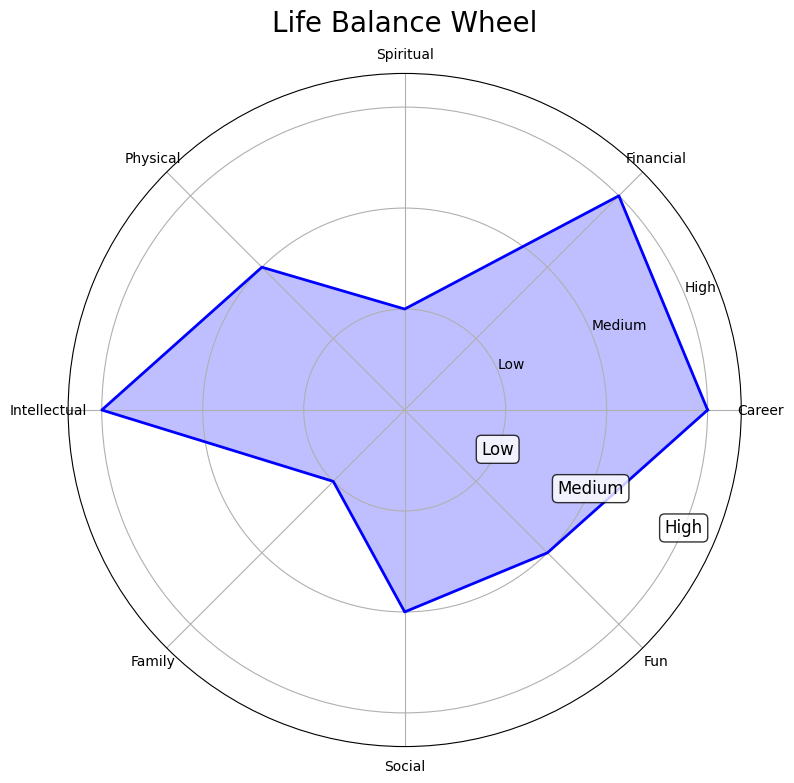

In [8]:
# Young professional focused on career growth
young_prof_priorities = {
    "Career": "High",
    "Financial": "High",
    "Spiritual": "Low",
    "Physical": "Medium",
    "Intellectual": "High",
    "Family": "Low",
    "Social": "Medium",
    "Fun": "Medium"
}

show_example_scenario(
    "Young Professional",
    age=28,
    marital_status="Single",
    occupation="Full-time",
    budget=4000,
    personality="Ambivert",
    hobby="Reading",
    priorities=young_prof_priorities
)

### Example 2: Parent Balancing Family and Health

🧑‍💼 Example Scenario: Parent Balancing Family and Health
Age: 42
Marital Status: Married
Occupation: Full-time
Budget: $5000/month
Personality: Extrovert
Primary Hobby: Exercise

Life Priorities:
- Career: Medium
- Financial: Medium
- Spiritual: Medium
- Physical: High
- Intellectual: Low
- Family: High
- Social: Low
- Fun: Medium
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

🌟 Top Personalized Recommendations:
1. Plan family outings (Confidence: 99%)
2. Host weekly family game nights (Confidence: 99%)
3. Attend regular preventative medical checkups (Confidence: 99%)
4. Eat healthy foods (Confidence: 99%)
5. Consider getting a gym membership (Confidence: 88%)


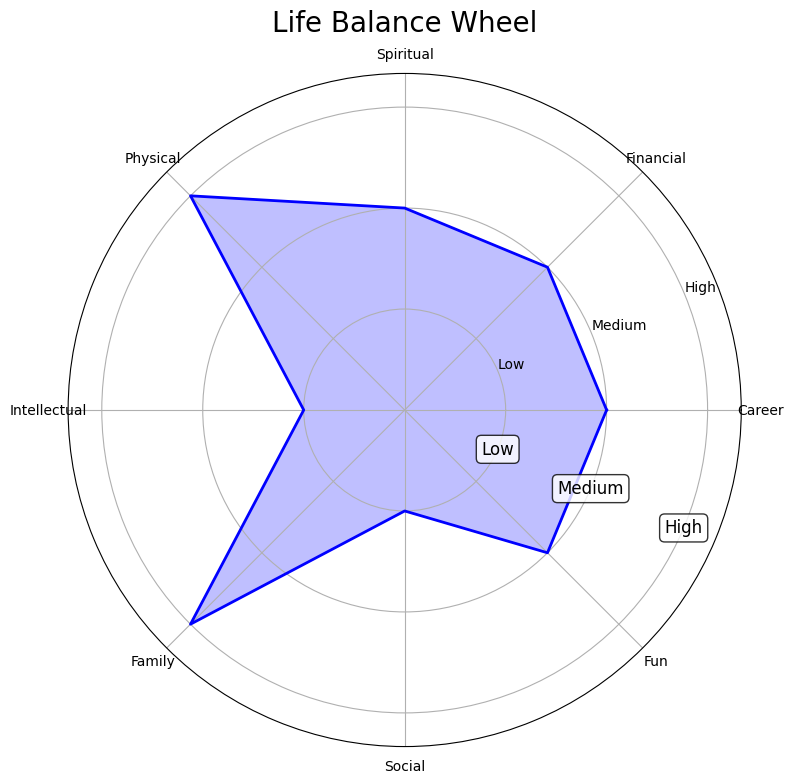

In [9]:
# Parent focused on family and health
parent_priorities = {
    "Career": "Medium",
    "Financial": "Medium",
    "Spiritual": "Medium",
    "Physical": "High",
    "Intellectual": "Low",
    "Family": "High",
    "Social": "Low",
    "Fun": "Medium"
}

show_example_scenario(
    "Parent Balancing Family and Health",
    age=42,
    marital_status="Married",
    occupation="Full-time",
    budget=5000,
    personality="Extrovert",
    hobby="Exercise",
    priorities=parent_priorities
)

### Example 3: Retiree Seeking Social Connection

🧑‍💼 Example Scenario: Retiree Seeking Social Connection
Age: 65
Marital Status: Married
Occupation: Unemployed
Budget: $3000/month
Personality: Extrovert
Primary Hobby: Art

Life Priorities:
- Career: Low
- Financial: Medium
- Spiritual: High
- Physical: High
- Intellectual: Medium
- Family: High
- Social: High
- Fun: High
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

🌟 Top Personalized Recommendations:
1. Spend time in nature (Confidence: 99%)
2. Allocate time for meditation or reflective practices (Confidence: 99%)
3. Eat healthy foods (Confidence: 99%)
4. Attend regular preventative medical checkups (Confidence: 99%)
5. Plan family outings (Confidence: 99%)
6. Host weekly family game nights (Confidence: 99%)
7. Participate in group adventure activities or social game nights (Confidence: 79%)


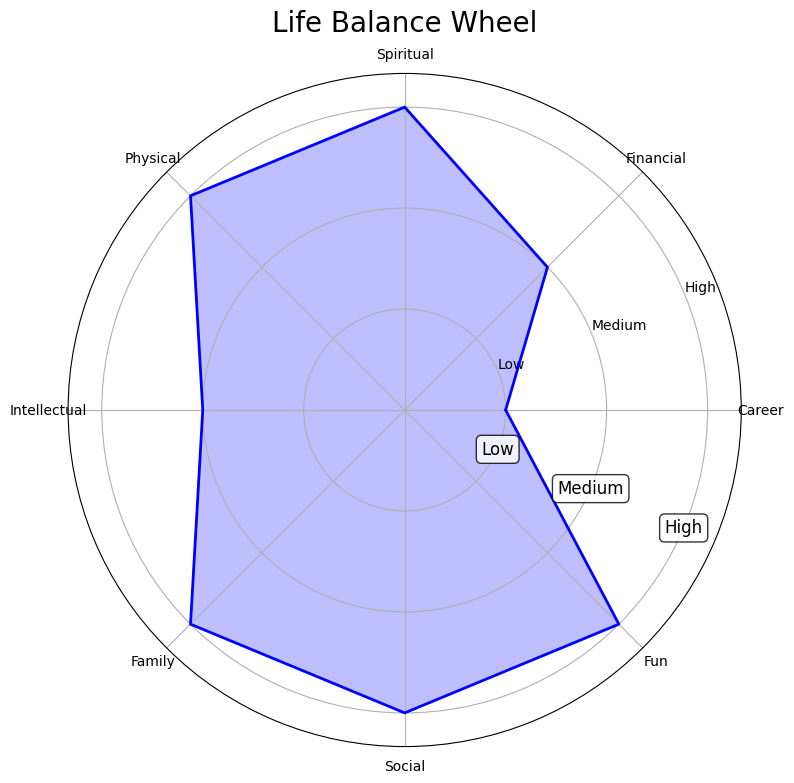

In [10]:
# Retiree seeking social connection
retiree_priorities = {
    "Career": "Low",
    "Financial": "Medium",
    "Spiritual": "High",
    "Physical": "High",
    "Intellectual": "Medium",
    "Family": "High",
    "Social": "High",
    "Fun": "High"
}

show_example_scenario(
    "Retiree Seeking Social Connection",
    age=65,
    marital_status="Married",
    occupation="Unemployed",
    budget=3000,
    personality="Extrovert",
    hobby="Art",
    priorities=retiree_priorities
)

## Saving User Profiles and Recommendations

In [11]:
def save_user_profile(name, age, marital_status, occupation, budget,
                      personality, hobby, priorities, recommendations):
    """
    Save a user profile and recommendations to a CSV file.

    Parameters:
    -----------
    name : str
        User name
    age, marital_status, etc. : user attributes
    priorities : dict
        Dictionary of domain priorities
    recommendations : list
        List of (recommendation, probability) tuples
    """
    # Create a directory for saved profiles if it doesn't exist
    os.makedirs("saved_profiles", exist_ok=True)

    # Prepare data for the CSV file
    profile_data = {
        "Name": name,
        "Age": age,
        "Marital Status": marital_status,
        "Occupation": occupation,
        "Budget": budget,
        "Personality": personality,
        "Hobby": hobby
    }

    # Add priorities
    for domain, priority in priorities.items():
        profile_data[f"{domain} Priority"] = priority

    # Add recommendations
    for i, (rec, prob) in enumerate(recommendations[:10]):  # Save top 10
        profile_data[f"Recommendation {i+1}"] = rec
        profile_data[f"Confidence {i+1}"] = prob

    # Create a DataFrame and save to CSV
    df = pd.DataFrame([profile_data])

    # Create a filename with timestamp
    import time
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f"saved_profiles/{name.replace(' ', '_')}_{timestamp}.csv"

    # Save to CSV
    df.to_csv(filename, index=False)
    print(f"Profile saved to {filename}")

    return filename

## Profile Management Interface


In [12]:
def create_profile_manager():
    """Create a profile management interface."""
    # Create widgets
    name_input = widgets.Text(
        value='',
        placeholder='Enter your name',
        description='Name:',
        style={'description_width': '100px'}
    )

    save_button = widgets.Button(
        description='Save Current Profile',
        button_style='info',
        icon='save'
    )

    load_dropdown = widgets.Dropdown(
        options=[],
        description='Load Profile:',
        style={'description_width': '100px'}
    )

    refresh_button = widgets.Button(
        description='Refresh Profiles',
        button_style='',
        icon='refresh'
    )

    output = widgets.Output()

    # Create a mock profile to save for demonstration purposes
    mock_profile = {
        "age": 35,
        "marital_status": "Single",
        "occupation": "Full-time",
        "budget": 3000,
        "personality": "Ambivert",
        "hobby": "Reading",
        "priorities": {
            "Career": "Medium",
            "Financial": "Medium",
            "Spiritual": "Medium",
            "Physical": "Medium",
            "Intellectual": "Medium",
            "Family": "Medium",
            "Social": "Medium",
            "Fun": "Medium"
        }
    }

    # Helper function to update profile list
    def update_profile_list():
        try:
            if not os.path.exists("saved_profiles"):
                os.makedirs("saved_profiles", exist_ok=True)

            profiles = os.listdir("saved_profiles")
            profiles = [p for p in profiles if p.endswith('.csv')]
            load_dropdown.options = profiles

            with output:
                print(f"Found {len(profiles)} saved profiles.")
        except Exception as e:
            with output:
                print(f"Error updating profile list: {e}")

    # Define button click handlers
    def on_save_clicked(b):
        with output:
            clear_output()

            if not name_input.value:
                print("Error: Please enter a name before saving.")
                return

            # For demonstration purposes, use the mock profile data
            try:
                # Generate mock recommendations
                user_features = [
                    mock_profile["age"],
                    marital_status_mapping[mock_profile["marital_status"]],
                    occupation_mapping[mock_profile["occupation"]],
                    mock_profile["budget"],
                    personality_mapping[mock_profile["personality"]],
                    hobby_mapping[mock_profile["hobby"]]
                ]

                # Add domain priorities
                for domain in ["Career", "Financial", "Spiritual", "Physical",
                              "Intellectual", "Family", "Social", "Fun"]:
                    user_features.append(priority_mapping[mock_profile["priorities"][domain]])

                # Get recommendations
                recommendations = get_recommendations(user_features)

                # Save profile
                filename = save_user_profile(
                    name_input.value,
                    mock_profile["age"],
                    mock_profile["marital_status"],
                    mock_profile["occupation"],
                    mock_profile["budget"],
                    mock_profile["personality"],
                    mock_profile["hobby"],
                    mock_profile["priorities"],
                    recommendations
                )

                print(f"Profile saved successfully to {filename}")

                # Update profile list
                update_profile_list()
            except Exception as e:
                print(f"Error saving profile: {e}")

    def on_refresh_clicked(b):
        with output:
            clear_output()
            print("Refreshing profile list...")
        update_profile_list()

    # Attach click handlers
    save_button.on_click(on_save_clicked)
    refresh_button.on_click(on_refresh_clicked)

    # Initial update of profile list
    update_profile_list()

    # Create layout
    manager = widgets.VBox([
        widgets.HTML("<h3>Profile Management</h3>"),
        widgets.HBox([name_input, save_button]),
        widgets.HBox([load_dropdown, refresh_button]),
        output
    ])

    return manager

## Export Recommendations as PDF

In [13]:
def create_pdf_report(name, age, marital_status, occupation, budget,
                    personality, hobby, priorities, recommendations,
                    filename="recommendations_report.pdf"):
    """
    Create a PDF report of recommendations.

    Note: This requires ReportLab library.
    Install it with: pip install reportlab
    """
    try:
        from reportlab.lib.pagesizes import letter
        from reportlab.lib import colors
        from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
        from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    except ImportError:
        print("ReportLab library not installed. Install with: pip install reportlab")
        return

    # Create the PDF
    doc = SimpleDocTemplate(filename, pagesize=letter)
    story = []

    # Get styles
    styles = getSampleStyleSheet()
    title_style = styles['Title']
    heading_style = styles['Heading2']
    normal_style = styles['Normal']

    # Add title
    story.append(Paragraph(f"LifeHarmony Recommendations for {name}", title_style))
    story.append(Spacer(1, 12))

    # Add profile information
    story.append(Paragraph("Profile Information", heading_style))

    profile_data = [
        ["Age:", str(age)],
        ["Marital Status:", marital_status],
        ["Occupation:", occupation],
        ["Budget:", f"${budget}/month"],
        ["Personality:", personality],
        ["Primary Hobby:", hobby]
    ]

    profile_table = Table(profile_data, colWidths=[100, 300])
    profile_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (0, -1), colors.lightgrey),
        ('TEXTCOLOR', (0, 0), (0, -1), colors.black),
        ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
        ('FONTNAME', (0, 0), (-1, -1), 'Helvetica'),
        ('FONTSIZE', (0, 0), (-1, -1), 10),
        ('BOTTOMPADDING', (0, 0), (-1, -1), 6),
        ('LEFTPADDING', (0, 0), (-1, -1), 6),
        ('RIGHTPADDING', (0, 0), (-1, -1), 6),
        ('GRID', (0, 0), (-1, -1), 0.5, colors.grey),
    ]))

    story.append(profile_table)
    story.append(Spacer(1, 12))

    # Add priorities information
    story.append(Paragraph("Life Priorities", heading_style))

    priorities_data = [["Domain", "Priority"]]
    for domain, priority in priorities.items():
        priorities_data.append([domain, priority])

    priorities_table = Table(priorities_data, colWidths=[200, 200])
    priorities_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, -1), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, -1), 10),
        ('BOTTOMPADDING', (0, 0), (-1, -1), 6),
        ('GRID', (0, 0), (-1, -1), 0.5, colors.grey),
    ]))

    story.append(priorities_table)
    story.append(Spacer(1, 12))

    # Add recommendations
    story.append(Paragraph("Personalized Recommendations", heading_style))
    story.append(Spacer(1, 6))

    for i, (rec, prob) in enumerate(recommendations[:10]):  # Include top 10
        confidence = int(prob * 100)
        story.append(Paragraph(f"{i+1}. {rec} (Confidence: {confidence}%)", normal_style))
        story.append(Spacer(1, 6))

    # Add footer
    story.append(Spacer(1, 36))
    story.append(Paragraph("Generated by LifeHarmony AI Recommender System",
                         ParagraphStyle(name='Footer', parent=normal_style, alignment=1)))

    # Build the PDF
    doc.build(story)
    print(f"PDF report saved as {filename}")

    return filename

### Implementation Notes:

1. This preliminary application provides a basic interface for users to:
   - Input their personal information and life priorities
   - Visualize their current life balance through the Wheel of Life
   - Receive personalized recommendations
   - Save their profiles and export recommendations as PDF reports

2. Technical components:
   - Deep learning model for generating recommendations
   - Interactive UI using ipywidgets
   - Data visualization with Matplotlib
   - Profile management with CSV storage
   - PDF report generation with ReportLab

### Future Enhancements:

1. User Experience Improvements:
   - Add more detailed explanations for each recommendation
   - Implement a progress tracking system for users to mark completed recommendations
   - Add a feedback mechanism to improve future recommendations

2. Enhanced Visualizations:
   - Create more detailed visualizations showing the gap between current and desired states
   - Add recommendation categories visualization
   - Implement interactive charts that respond to user input changes

3. Advanced Features:
   - Recommendation scheduling based on time availability
   - Budget-based filtering of recommendations
   - Social sharing of accomplishments
   - Community features to connect with others with similar priorities

4. Technical Improvements:
   - Convert to a web application for broader accessibility
   - Implement user authentication and secure storage
   - Create a mobile app version
   - Add natural language processing for more personalized recommendation descriptions
"""

# Run the Application

In [14]:
# Run the complete application
def run_lifeharmony_application():
    """Run the complete LifeHarmony application."""
    # Display application header
    display(HTML("""
    <div style="background-color: #f5f5f5; padding: 20px; border-radius: 10px; margin-bottom: 20px; text-align: center;">
        <h1 style="color: #3366cc;">LifeHarmony</h1>
        <h3 style="color: #666;">AI Recommender System for a Balanced Life</h3>
    </div>
    """))

    # Create main application interface
    main_app = create_user_interface()

    # Create profile manager
    profile_manager = create_profile_manager()

    # Create tabs for the application
    app_tabs = widgets.Tab([main_app, profile_manager])
    app_tabs.set_title(0, "Recommendations")
    app_tabs.set_title(1, "Profile Management")

    # Display the application
    display(app_tabs)

    # Display footer
    display(HTML("""
    <div style="background-color: #f5f5f5; padding: 10px; border-radius: 10px; margin-top: 20px; text-align: center;">
        <p>LifeHarmony &copy; 2025 | Preliminary Application Version</p>
    </div>
    """))

# Run the application
run_lifeharmony_application()

# Usage Instructions


### Using the LifeHarmony Application:

1. Personal Information Tab:
   - Enter your age, marital status, occupation, budget, personality type, and primary hobby
   - Adjust the priority levels for each life domain based on your current focus
   - Click "Generate Recommendations" to receive personalized suggestions

2. Visualization Tab:
   - View your Wheel of Life visualization
   - Areas with "High" priority are where you should focus your improvement efforts
   - A balanced wheel would have similar values across all domains

3. Recommendations Tab:
   - Review your personalized recommendations
   - Each recommendation includes a confidence score indicating how well it matches your profile
   - Consider implementing the highest confidence recommendations first

4. Profile Management Tab:
   - Enter your name to save your current profile
   - Click "Save Current Profile" to store your information
   - Use the dropdown to load previously saved profiles
   - Click "Refresh Profiles" to update the list of available profiles

5. Exporting Recommendations:
   - To export your recommendations as a PDF report, use the PDF button in the recommendations tab
   - The PDF report includes your profile information, life priorities, and top recommendations
   - Save this report for future reference or to track your progress